In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Time series analysis

### This section uses seasonally non-adjusted quarterly data on income and consumption in the UK.


In [2]:
df = pd.read_csv('./data/incomeUK.csv')
df.head()

,rownames,income,consumption
0,1,9014,8016
1,2,9659,8798
2,3,9848,9184
3,4,10316,9755
4,5,10254,9113


<Axes: >

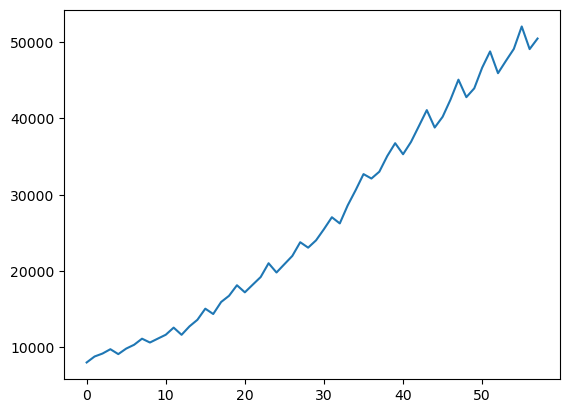

In [3]:
consumption = df['consumption']
consumption.plot()

## Pre analysis

As seen in the plot, there is clear seasonality in the dataset, where is a clear trend taken place while up and down in some frequency. Using seasonal ARIMA model to fit the data seems the best fit. Using a ACF plot to better illustrate the point I made.

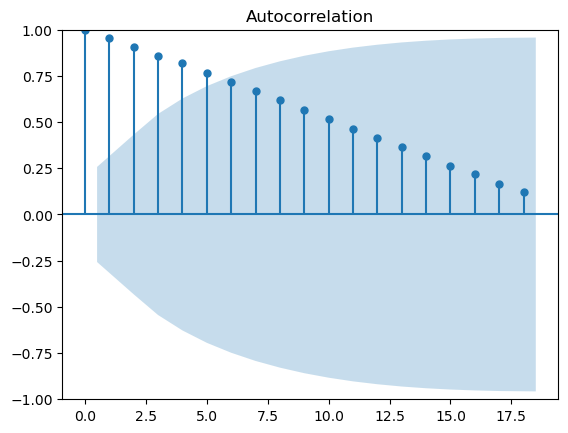

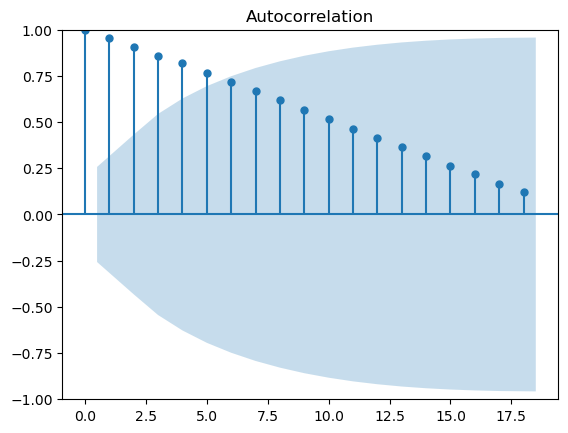

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(consumption)

# ACF plot

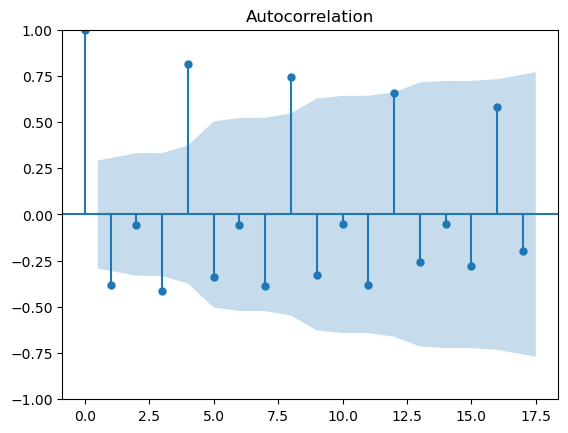

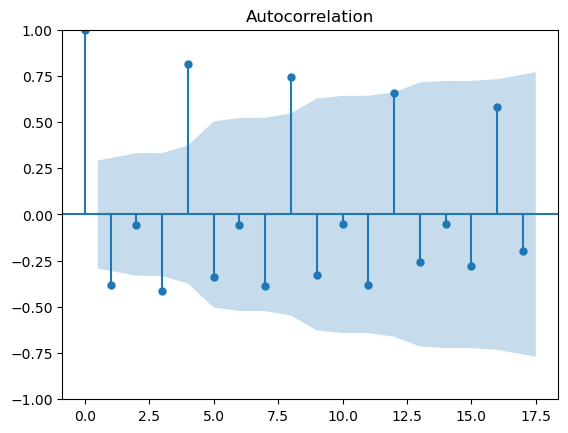

In [59]:
log_consumption = np.log(consumption)
n = len(log_consumption)
train_log_consumption = log_consumption[:int(n*0.8)]
test_log_consumption = log_consumption[int(n*0.8):]
plot_acf(train_log_consumption.diff().dropna())

By looking at the log difference of the data, we can see clear seasonality in the time series where there is negative correlation between current consumption and recent consumption.

# PACF plot

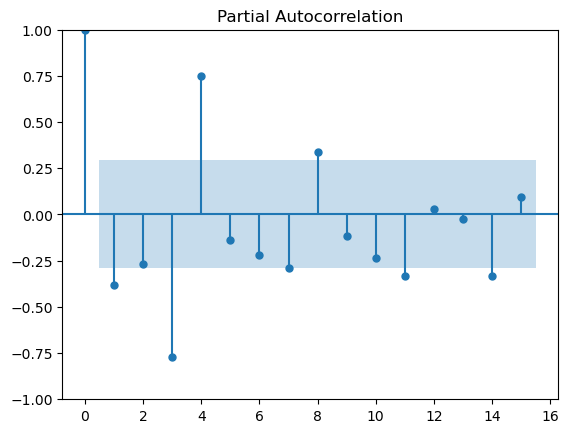

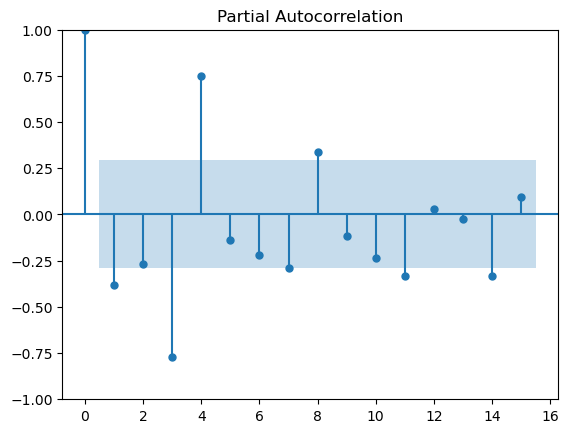

In [60]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_log_consumption.diff().dropna(), lags = 15, method = "ols")

We can see that the after first difference, the model becomes stationary, so we will use (0, 1, 0) for non seasonal model, and (0, 1, 1)[4] for seasonal component.

In [16]:
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [61]:
model = SARIMAX(train_log_consumption, order = (0, 1, 0), seasonal_order=(0, 1, 1, 4))
result = model.fit()
print(result.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.27240D+00    |proj g|=  6.63958D+00

At iterate    5    f= -2.27587D+00    |proj g|=  1.49083D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     50      2     0     0   1.491D-03  -2.276D+00
  F =  -2.2758660440150522     

ABNORMAL_TERMINATION_IN_LNSRCH                              
                                      SARIMAX Results                                      
Dep. Variable:                         c

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/tonghuang/opt/anaconda3/envs/nlp/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


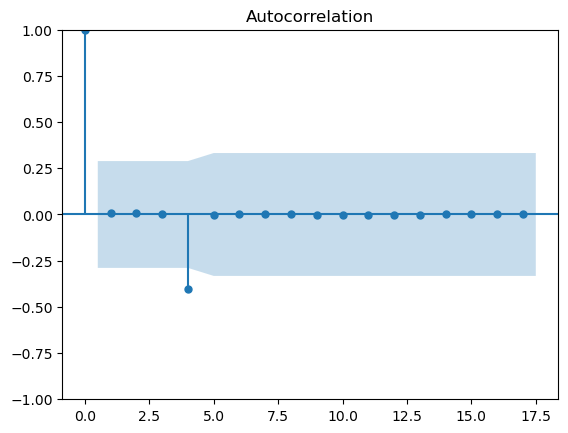

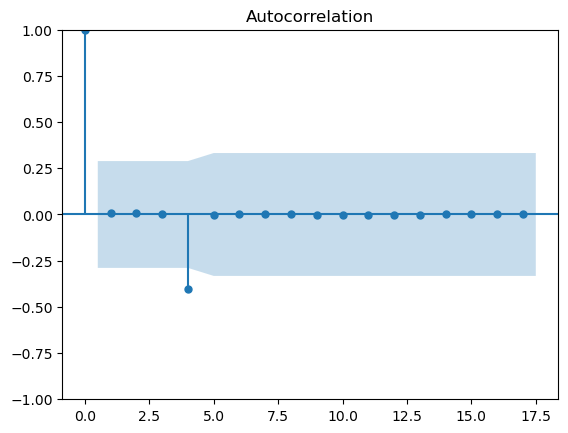

In [62]:
plot_acf(result.resid)

In [86]:
model_2 = pm.AutoARIMA(seasonal=True)
model_2.fit(train_log_consumption)
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   46
Model:               SARIMAX(1, 1, 2)   Log Likelihood                  80.985
Date:                Fri, 26 Apr 2024   AIC                           -151.970
Time:                        12:22:36   BIC                           -142.937
Sample:                             0   HQIC                          -148.603
                                 - 46                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0713      0.005     14.230      0.000       0.061       0.081
ar.L1         -0.9993      0.019    -53.665      0.000      -1.036      -0.963
ma.L1          0.3827      0.268      1.430      0.153      -0.142       0.907
ma.L2         -0.5900      0.202     -2.921      0.003      -0.986      -0.194
sigma2         0.0015      0.001      2.695      0.007       0.000       0.003
===================================================================================
Ljung-Box (L1) (Q):                   1.94   Jarque-Bera (JB):                 2.56
Prob(Q):                              0.16   Prob(JB):                         0.28
Heteroskedasticity (H):               0.85   Skew:                            -0.18
Prob(H) (two-sided):                  0.76   Kurtosis:                         1.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model selected by auto.arima yields better AIC and BIC performance than the previous model, but it shows no seasonal component for the data.

# Let's plot both model's prediction for the following 8 quarters

In [87]:
model_2.predict()

46    10.650339
47    10.713406
48    10.721648
49    10.784676
50    10.792958
51    10.855946
52    10.864267
53    10.927215
54    10.935576
55    10.998485
dtype: float64

In [88]:
result.predict(int(n*0.8), )

46    10.659997
dtype: float64

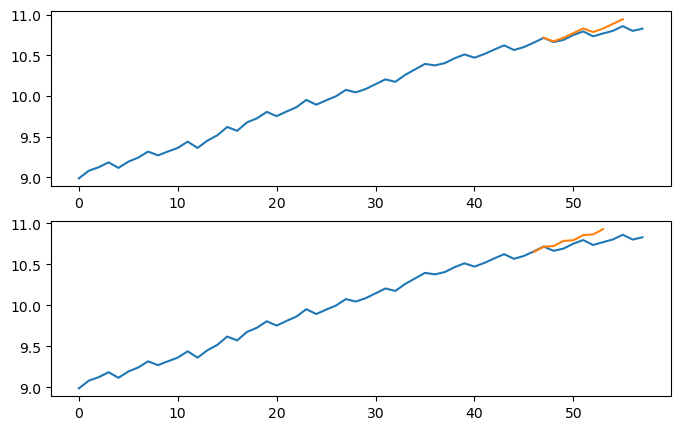

In [90]:
n_consump = len(log_consumption)

fig, axes = plt.subplots(2, figsize = (8, 5))

model_1_pred = result.predict(int(n*0.8)+1, int(n*0.8)+9)
model_2_pred = model_2.predict(8)

axes[0].plot(log_consumption)
axes[0].plot(model_1_pred)

axes[1].plot(log_consumption)
axes[1].plot(model_2_pred)


The first model is better based on the prediction plot that are shown above.

# Regression with HAC Standard Errors

For this section, we compute the OLS estimates of the regression of the differenced one-month T-bill rates, tb1 diff, on the differenced
three-month T-bill rates, tb3 diff.

In [99]:
from statsmodels.api import OLS

In [94]:
df = pd.read_csv('./data/Mishkin.csv', index_col='rownames')
df.head()

,pai1,pai3,tb1,tb3,cpi
rownames,,,,,
1,-3.552289,1.129370,1.100854,1.129406,23.5
2,5.247540,4.001566,1.125513,1.137254,23.6
3,1.692860,4.492160,1.115715,1.142319,23.6
4,5.064298,7.817513,1.146380,1.177902,23.7
5,6.719322,9.433580,1.158520,1.167777,23.8


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 491 entries, 1 to 491
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pai1    491 non-null    float64
 1   pai3    491 non-null    float64
 2   tb1     491 non-null    float64
 3   tb3     491 non-null    float64
 4   cpi     491 non-null    float64
dtypes: float64(5)
memory usage: 23.0 KB


In [98]:
tb1_diff = df['tb1'].diff().dropna()
tb3_diff = df['tb3'].diff().dropna()

In [103]:
model = OLS(tb1_diff, tb3_diff).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    tb1   R-squared (uncentered):                   0.572
Model:                            OLS   Adj. R-squared (uncentered):              0.572
Method:                 Least Squares   F-statistic:                              654.8
Date:                Fri, 26 Apr 2024   Prob (F-statistic):                    2.82e-92
Time:                        12:27:53   Log-Likelihood:                         -311.73
No. Observations:                 490   AIC:                                      625.5
Df Residuals:                     489   BIC:                                      629.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
tb3            0.9447      0.037     25.588      0.000       0.872       1.017
==============================================================================
Omnibus:                       59.563   Durbin-Watson:                   2.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              467.864
Skew:                          -0.009   Prob(JB):                    2.54e-102
Kurtosis:                       7.787   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

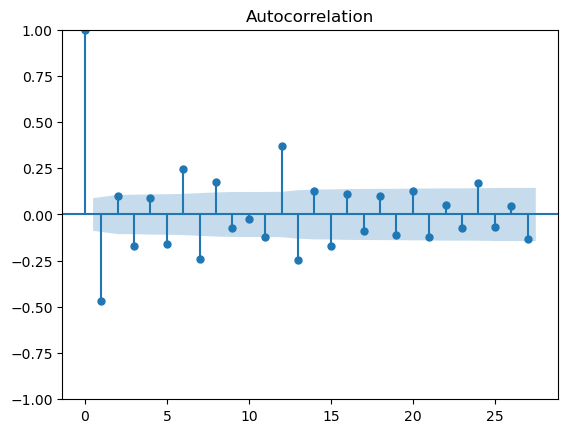

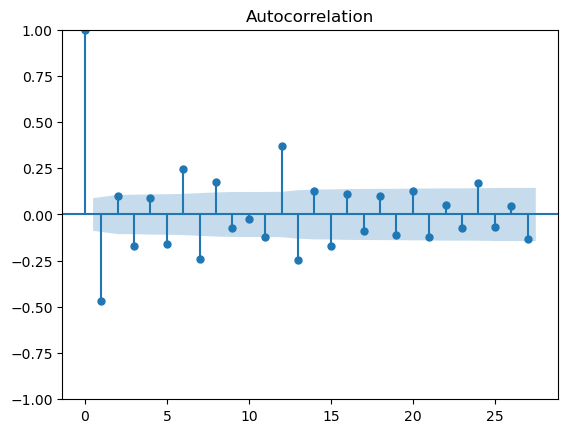

In [107]:
plot_acf(model.resid)

Based on the acf plot of the residual, we can see that there is clear autocorrelation between residuals. 

In [111]:
nw_se = model.get_robustcov_results(cov_type='HAC', maxlags=0).bse
t_stats = model.params / nw_se

print("Standard errors:", nw_se)
print("t-Statistics:", t_stats)

Standard errors: [0.08010965]
t-Statistics: tb3    11.792946
dtype: float64
